# **Assignment 3**

#### **MSc** Scientific and Data Intensive Computing,
#### University College London, 2021-2022

#### Techniques of High Performance Computing (PHAS0102)

###**Cong Zheng** 
### **Student ID: 21055428**

## Table of Contents
#### 1. Introduction
#### 2. Task1: Exploring the Ellpack-R format in GPUs
###### 2.1 Overview of the various formats
###### 2.2 Summary of the difficulties of the CSR format
###### 2.3 How Ellpack and Ellpack-R address these difficulties
###### 2.4 Advances in GPU-based matvec technology
#### 3. Task2: CUDA-based matvec computation in Ellpack-R format
###### 3.1 Conversion from CSR format to Ellpack-R format
###### 3.2 CUDA-based matvec computation in Ellpack-R format
###### 3.3 Verification using random sparse matrices
###### 3.4 Verification using discretise_poisson matrices
###### 3.5 Validation using matrices purchased from the matrix market

#### 4. Conclusion
#### 5. Reference

## 1. Introduction

Sparse matrix vector multiplication (SpMV) is not negligible in the field of scientific computing, such as iterative methods for solving linear systems and eigenvalue problems. The performance of SpMV is largely determined by the format of the sparse matrix, which is a standard format widely used on CPUs. However, it has some serious drawbacks on the GPU and also on modern vector extensions to the CPU (AVX etc.). The Ellpack-R format, on the other hand, improves on the shortcomings of CSR on the GPU and offers higher performance on these devices.

In this solution, we explore the performance of the GPU-based Ellpack-R format for sparse matrix multiplication. First, in Chapter 2 we summarise the shortcomings of the CSR format based on the literature of Vazquez et. al and explain the advantages of the Ellpack and Ellpack-R counterparts, and further describe the subsequent directions of development. Afterwards, in Chapter 3, we first build a new class of EllpackMatrix based on Ellpack-R for implementing matrix vector multiplication and perform a benchmark comparison using random sparse matrices, discrete Poisson matrices and other matrices.



## 2. Task1: Exploration of the Ellpack-R format in GPU-based

Sparse matrices have found specific applications in many engineering fields. In real production environments, the most efficient storage solution is to store only the non-zero elements of the matrix in order to save memory. And the main bottleneck for iterative solution of specific engineering systems is the sparse matrix-vector multiplication method, which is used repeatedly until the iterative process reaches convergence. The advent of the GPU has made it possible to break the performance limit of SpMV computation. Therefore, it is important to design a sparse matrix storage format that can be efficiently utilised in GPUs.

### 2.1 Overview of the various formats


With the development of modern scientific computing, a number of mainstream sparse matrix storage formats already exist.

* The Coordinate (COO) storage format is the most straightforward and simplest solution. When matrices are stored out of order, SpMV calculations based on the COO format are not suitable for GPU architectures. In this case, multiple threads will access data and write vectors in a discontinuous manner. On the other hand, this format will take up more memory than the CSR format.
* Compressed sparse row (CSR) format is the most common format for storing sparse matrices in the CPU. However, it has poor performance due to the fact that in the GPU so all threads access the data in a discontinuous manner.
* The Ellpack format can be thought of as a way to fit sparse matrices into a regular data structure similar to a dense matrix. When the number of non-zeros in each row is almost equal, the number of zeros to be filled is reduced, which leads to high performance in achieving SpMV on the GPU. However, when the number of non-zeros in each row differs by a large amount, more zeros need to be filled, which leads to a reduction in computational performance.
* The ELLPACK-R format makes a number of changes and optimisations to the Ellpack format. For example, it has better cohesion for global memory accesses and reduces the waiting time for a warp.
* BiELL format
The BiELL format is a double-cut ELL format. Based on the ELL format, it balances the workload of different threads in a warp and therefore reduces the wait time.

* The Jagged Diagonal (JAD) format stores non-zeros on a jagged diagonal. JAD reduces the number of zeros that need to be filled, which leads to better performance than the Ellpack format.
* The Bi-Cut JAD (BiJAD) format is a bi-cut of JAD, which is an optimised and improved version of JAD for the GPU.

### 2.2 Summary of the difficulties of CSR format


Compressed Row Storage (CRS) is the most widely used format for storing sparse matrices on the CPU.
Specifically, let N and Nz be the number of rows of the matrix and the total number of non-zero entries of the matrix, respectively. The data structure of the matrix consists of the following arrays.
* A[ ] array. A floating-point array of dimension Nz to store the data.
* J[ ] array of integers of dimension Nz. An integer array of dimension Nz used to store the indexes of its columns.
* Indptr[ ] An array of integers of dimension N+1. Pointer to the beginning of each row in A[] and J[], both of which are sorted by row index.

The CRS-based code for computing SpMV has several drawbacks that hinder optimizing the performance of this code on the GPU.
* First, the local accessibility of vector v[] is not maintained due to indirect addressing. This results in the data manipulated by neighbouring threads not being contiguous in the memory address, which makes for poor computational performance.
* Secondly, the fine-grained parallelism is not exploited because the number of iterations of the inner loop is small and variable.


### 2.3 How Ellpack and Ellpack-R solve these difficulties


The Ellpack format was introduced as a format for compressing sparse matrices in order to solve large sparse linear systems on vector computers with the ITPACKV subroutine. This format stores sparse matrices in two arrays. One is a floating-point array A[ ], which holds the data, and the other is an integer array J[ ], which holds the column indices of each entry. Where both arrays are stored in column-first form.

In the Ellpack-R format, an additional array, rl[ ], is introduced to store the number of non-zeros in each matrix row.

In GPU architectures, SpMV based on Ellpack-R has superior computational performance compared to the CSR format for the following reasons.
* No synchronous execution. Each thread is mapped to a row that computes an element of the output vector y. The thread mapping used in this implementation allows synchronous-free execution, with no data dependencies between threads or even between blocks. This allows for better computational performance without threads having to wait for each other.
* Coalescing of global memory accesses. In the Ellpack-R format, the thread represented by index i accesses the element in row i of the original array. Due to the column-major ordering of the matrix elements stored into the data structure, the two threads i and i+1 access consecutive memory addresses, thus satisfying the coalescence condition for global memory accesses. Enables SpMV operations in the Ellpack-R format to have superior computational performance to the CSR format where memory accesses are not contiguous.
* Divergence-free execution. Threads execute the same instructions. For example, because the length of each line is known, inner loops that perform multiplication and addition operations do not need to include conditional branches to check for padding elements. Therefore, there are no data dependencies or control flows causing threads to diverge between the same or different warps.

### 2.4 Advances in GPU-based matvec technology

Over the past few years, as GPUs have become a popular platform for scientific computing, SpMV operations can now be extended to GPUs to take advantage of the massive parallelism offered by their multi-core architecture. As a result, much work has been done to optimise SpMV operations for GPUs.


Researchers have proposed different optimisation strategies and data formats to improve SpMV performance for different kinds of matrix structures and different hardware architectures.

A. Monakov's research team [1] proposed a new format, Sliced-ELLPACK, based on the Ellpack-R format, to improve the performance of SpMV operations on GPUs. In [2], the Jagged Diagonal (JAD) format was used to implement the SpMV kernel for better performance. The BiELL format in [3] uses a sectioning technique to improve the performance of the ELL format. In addition, more different kinds of storage formats have been proposed [4] [5].


In addition, the performance improvement of SpMV can be achieved with high precision by other linear algebra kernels.Isupov, Konstantin et al. implemented SpMV based on GPU architecture and Ellpack-R format using three multi-precision libraries, namely CUMP, CAMPARY and MPRES-BLAS [6].Hishinuma T et al. and Nakata M's research team [7][8] used double computation to improve the quadruple accuracy of SpMV. In this approach, two double-precision variables are used to represent a four-precision variable.



## 3. Task 2: CUDA-based matvec computation in Ellpack-R format



To practically investigate the performance improvement of the Ellpack-R format for matrix vector multiplication, we further compare the performance difference between matrix vector multiplication in CSR format and Ellpack-R format in Chapter 3. Specifically, we implement a new class of EllpackMatrix for matrix vector multiplication using the Ellpack-R format and perform a comparative timing analysis using a 1000*1000 random sparse matrix, a discretise_poisson sparse matrix and several matrices from the matrix market respectively.

### 3.1 Conversion from CSR format to Ellpack-R format

To further explore the superiority of the Ellpack-R format, we wrote a CPU-based Numba program that converts matrices stored in CSR format to Ellpack-R format.

First, we introduced the required libraries and packages.

In [ ]:
import numpy 

from numba import cuda
from numba import prange 
from numba import jit

from scipy.io import mmread
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import LinearOperator

from matplotlib import pyplot as plt

%matplotlib inline

To implement the conversion of matrices from CSR format to Ellpack-R format, we designed the toEllpackR function, which uses the jit compilation speedup in numba.

Following the Ellpack-R format described in the paper [], we store the matrix A, matrix J in a one-dimensional array in column-first form. We end up with an array A that stores the data in the matrix in CSR format, an array J that stores the column indices, and an array rl that stores the number of non-zero items per row.

In [ ]:
@jit(parallel=True)
def toEllpackR(A_csr):

    N = len(A_csr.indptr) -1

    A = numpy.zeros(shape = [N, N])
    J = numpy.zeros(shape = [N, N])
    rl = numpy.zeros(shape = N)  

    for i in prange(N):
        X = A_csr.indptr[i+1] - A_csr.indptr[i]
        rl[i] = int(X)
        for j in range(X):
            A[i,j] = float(A_csr.data[j + A_csr.indptr[i]])
            J[i,j] = int(A_csr.indices[j + A_csr.indptr[i]])

    A = A.reshape((1, -1),order = 'F')
    J = J.reshape((1, -1),order = 'F')

    A = A[0]
    J = J[0]
      
    return A, J, rl       

### 3.2 CUDA-based matvec calculation in Ellpack-R format

To verify the superiority of the Ellpack-R format for matrix-vector multiplication, we have implemented a new class, EllpackMatrix, derived from scipy.sparse.linalg.LinearOperator, with the difference that while the normal matrix-vector multiplication is based on the CSR format, EllpackMatrix In EllpackMatrix, we implement matrix multiplication based on the Ellpack-R format.

To verify the superiority of Ellpack-R in the GPU, we wrote DoCalc_Ellpack, a computational kernel for implementing matrix vector multiplication, based on the Numba-Cuda architecture.

In [ ]:
@cuda.jit
def DoCalc_Ellpack(A, J, rl, vec, res):
    
    N = len(res)
    idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if(idx < N):

        tmp = 0.0
        max = rl[idx]
        
        for j in range(max):

            data_A = A[j*N + idx]
            data_vec = vec[int(J[j*N + idx])]
            tmp += data_A*data_vec
      
        res[idx][0] = tmp 
  

In the CUDA calculation kernel DoCalc_Ellpack, we have set each thread to calculate a different row. In contrast, in the toEllpackR function we have specified that matrices in Ellpack-R format are stored in column-first array format, which also makes the memory accessed by neighbouring threads contiguous, which avoids the unnecessary time consumption caused by discontinuous memory accesses in traditional matrix vector multiplication.

In [ ]:
class EllpackMatrix(LinearOperator):

    def __init__(self, csr_mat):

        shape = (csr_mat.shape[1], csr_mat.shape[0])
        super().__init__(dtype=csr_mat.dtype, shape = shape)

        self.A, self.J, self.rl = toEllpackR(csr_mat)

    def _matvec(self, vec):
        blockdim = 32*32
        griddim = int(numpy.ceil(self.shape[0]/blockdim))

        N= self.shape[1]

        vec = vec.reshape((1, -1))[0]
    
        A_device = cuda.to_device(self.A)
        J_device = cuda.to_device(self.J)
        rl_device = cuda.to_device(self.rl)
        vec_device = cuda.to_device(vec)

        res_device = cuda.device_array((N,1), dtype = numpy.float64)
          
        DoCalc_Ellpack[griddim, blockdim](A_device, J_device, rl_device, vec_device, res_device)
 
        res_host = res_device.copy_to_host()
   
        return res_host

    


Next, we implement a new class EllpackMatrix derived from scipy.sparse.linalg.LinearOperator.

Specifically, we take a Scipy sparse matrix in CSR format in its constructor and convert it to Ellpack-R format.

In addition, we rewrite the _matvec function for implementing matrix vector products in Ellpack-R format. Firstly, we specified the dimension of the thread block to be 32*32 and specified that the dimension of the thread grid could vary with the matrix dimension to avoid unnecessary expenditure on thread switches. Afterwards, we transferred the matrices A, J, rl and the vector vec from the host side to the device and performed the matrix-vector product calculation in the Ellpack-R format in the calculation kernel DoCalc_Ellpack. Finally, the result of the calculation res is returned to the host side.

### 3.3 Verification using random sparse matrices

To demonstrate that my solution provided the correct results, we performed accuracy verification using sparse random matrices.

Specifically, we created a 1000*1000 sparse random matrix and used three different random vectors to multiply with it based on the Ellpack-R format and compared it with the standard CSR sparse matrix matvec product.

Firstly, we created the sparse random matrix A_random with dimension 1000*1000 and sparsity 1%, which was set to be stored in coo format. and converted it to csr_mat in CSR format.

In [ ]:
m = 1000
n = 1000
density = 0.01
matrixformat = 'coo'

A_random = scipy.sparse.rand(m, n, density=density, format=matrixformat, dtype=None)
csr_mat = csr_matrix(A_random)

Afterwards, tests were carried out in order to prove that the new class we had implemented was capable of implementing the prototype commands in the job.

In [ ]:
my_sparse_mat = EllpackMatrix(csr_mat)
x = numpy.random.randn(my_sparse_mat.shape[1])
y = my_sparse_mat @ x

Afterwards, we created three different random vectors x, x_1 and x_2, all of dimension 1000, and performed matrix vector multiplication based on CSR format and Ellpack-R format respectively.

To verify the correctness of this solution, we calculated the relative distances of the three sets of Ellpack-R matvec and CSR matvec results, respectively.

In [ ]:
def get_rel_distance(csr_mat, x):
    y_csr = csr_mat @ x
    y_ellpackr = my_sparse_mat @ x
    rel_error = numpy.linalg.norm(y_ellpackr - y_csr, numpy.inf) / numpy.linalg.norm(y_csr, numpy.inf)
    return rel_error

In [ ]:
print(get_rel_distance(csr_mat, x))

x_1 = numpy.random.randn(my_sparse_mat.shape[1])
print(get_rel_distance(csr_mat, x_1))

x_2 = numpy.random.randn(my_sparse_mat.shape[1])
print(get_rel_distance(csr_mat, x_2))


2.0798216370792914e-16
1.383722422803408e-16
1.9127382819345173e-16


The relative distances of the matrix multiplication of the three sets of random vectors can be observed to be 2.0798216370792914e-16, 1.383722422803408e-16, and 1.9127382819345173e-16 respectively, all reaching the 1e-16 level. It is demonstrated that the solution can effectively implement matrix vector multiplication based on the Ellpack-R format.

### 3.4 Validation using the discretise_poisson matrix


To further verify the accuracy of this solution, we also used a discrete Poisson sparse matrix for verification.

The discretise_poisson function used to generate the discrete sparse matrix is shown below and is used to return a matrix of dimension [N*N, N*N] and a vector f of dimension [N*N,1] stored in CSR format.

In [ ]:
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    nelements = 5 * N**2 - 16 * N + 16
    row_ind = numpy.empty(nelements, dtype=numpy.float64)
    col_ind = numpy.empty(nelements, dtype=numpy.float64)
    data = numpy.empty(nelements, dtype=numpy.float64)
    f = numpy.empty(N * N, dtype=numpy.float64)
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i                 
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                count += 5                                  
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

Afterwards, in order to explore the performance differences in terms of computation time of the Ellpack-R format, we conducted a benchmarking comparison analysis.

Specifically, we selected matrix dimensions of 100, 900, 2500, 4900 and 8100, respectively, and used matvec in csr format and our own Ellpack-R implementation to plot the time variation trend of matvec in different matrix dimensions, respectively.

In [ ]:
timeit_result1 = numpy.zeros(5, dtype=numpy.float64)
timeit_result2 = numpy.zeros(5, dtype=numpy.float64)

for loop in range(10,100,20):
    x = numpy.random.randn(loop*loop, 1)
    A_poisson_CSR,_ = discretise_poisson(loop)
    A_poisson_EllpackR = EllpackMatrix(A_poisson_CSR)
    timeit_result_1 = %timeit -o A_poisson_CSR@x
    timeit_result1[int(loop//20)] = timeit_result_1.best
    timeit_result_2 = %timeit -o A_poisson_EllpackR@x
    timeit_result2[int(loop//20)] = timeit_result_2.best


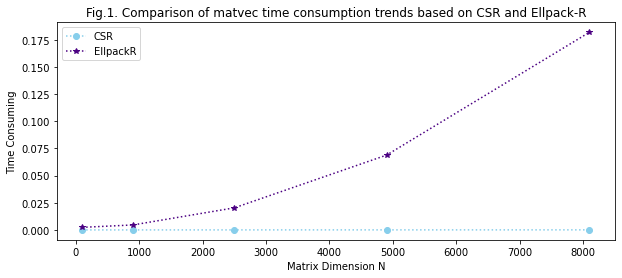

In [ ]:
x_fit = [100, 900, 2500, 4900, 8100]
plt.figure(figsize=(10,4))
plt.plot(x_fit,timeit_result1, ':',label = 'CSR',color='skyblue', marker = 'o')
plt.plot(x_fit,timeit_result2, ':',label = 'EllpackR',color='indigo', marker = '*')
plt.xlabel('Matrix Dimension N')
plt.ylabel('Time Consuming')
plt.title('Fig.1. Comparison of matvec time consumption trends based on CSR and Ellpack-R')
plt.legend()
plt.show()

Looking at Figure 1, we can see that matvec based on the CSR format has better performance than matvec based on the Ellpack-R format.

Specifically, when the matrix and vector dimensions are [2500, 2500]*[2500, 1], respectively, matvec in CSR format takes only 27.7 µs, much less than the 20.3 ms of matvec in Ellpack-R format. time is almost 1000 times that of CSR, and this gap is gradually widening further as the matrix dimension N increases.

This is probably because the multiplication of sparse matrices and vectors comes from a very simple 2D problem with few elements per row, resulting in very limited optimisation in the Ellpack-R format.

### 3.5 Validation of matrices purchased using the matrix market

To further validate the practical effectiveness of matrix vector multiplication based on the Ellpack-R format, four different matrices were selected in the matrix market. and performed a comparative analysis of the benchmark tests conducted in 3.4.

Specifically, we selected four different matrices, namely mcca, mcfe, gre__115 and gre__185.

In [ ]:
Mat_mcca = scipy.io.mmread('mcca.mtx')
Mat_mcfe = scipy.io.mmread('mcfe.mtx')
Mat_gre__115 = scipy.io.mmread('gre__115.mtx')
Mat_gre__185 = scipy.io.mmread('gre__185.mtx')

Mat_mcca_CSR = Mat_mcca.tocsr(Mat_mcca)
Mat_mcfe_CSR = Mat_mcfe.tocsr(Mat_mcfe)
Mat_gre__115_CSR = Mat_gre__115.tocsr(Mat_gre__115)
Mat_gre__185_CSR = Mat_gre__185.tocsr(Mat_gre__185)

Mat_mcca_EllpackR = EllpackMatrix(Mat_mcca_CSR)
Mat_mcfe_EllpackR = EllpackMatrix(Mat_mcfe_CSR)
Mat_gre__115_EllpackR = EllpackMatrix(Mat_gre__115_CSR)
Mat_gre__185_EllpackR = EllpackMatrix(Mat_gre__185_CSR)

x_mcca = numpy.random.randn(Mat_mcca.shape[1])
x_mcfe = numpy.random.randn(Mat_mcfe.shape[1])
x_gre__115 = numpy.random.randn(Mat_gre__115.shape[1])
x_gre__185 = numpy.random.randn(Mat_gre__185.shape[1])

timeit_result_csr_01 = %timeit -o Mat_mcca_CSR@x_mcca
timeit_result_csr_02 = %timeit -o Mat_mcfe_CSR@x_mcfe
timeit_result_csr_03 = %timeit -o Mat_gre__115_CSR@x_gre__115
timeit_result_csr_04 = %timeit -o Mat_gre__185_CSR@x_gre__185

timeit_result_ellpackr_01 = %timeit -o Mat_mcca_EllpackR@x_mcca
timeit_result_ellpackr_02 = %timeit -o Mat_mcfe_EllpackR@x_mcfe
timeit_result_ellpackr_03 = %timeit -o Mat_gre__115_EllpackR@x_gre__115
timeit_result_ellpackr_04 = %timeit -o Mat_gre__185_EllpackR@x_gre__185

list0 = [timeit_result_csr_01.best, timeit_result_csr_02.best, timeit_result_csr_03.best, timeit_result_csr_04.best]
list1 = [timeit_result_ellpackr_01.best, timeit_result_ellpackr_02.best, timeit_result_ellpackr_03.best, timeit_result_ellpackr_04.best]

Similar to the results obtained in 3.4, matvec in CSR format has better performance than Ellpack-R format.

Specifically, for a matrix gre__185 with matrix dimension [185, 185], we used only 8.5 µs based on the CSR format, much less than the 2.4 ms required by the Ellpack-R format. It is easy to see that matrix multiplication based on the CSR format is almost 1000 times faster.

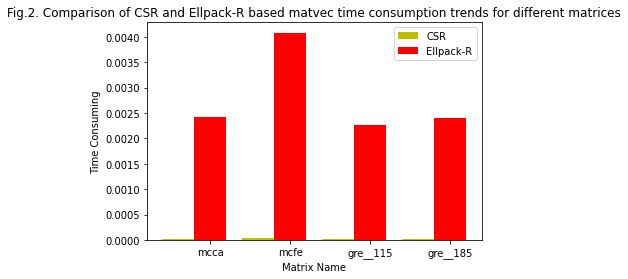

In [ ]:
name_list = ['mcca','mcfe','gre__115','gre__185']

x =list(range(len(list0)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, list0, width=width, label='CSR',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, list1, width=width, label='Ellpack-R',tick_label = name_list,fc = 'r')
plt.xlabel('Matrix Name')
plt.ylabel('Time Consuming')
plt.title('Fig.2. Comparison of CSR and Ellpack-R based matvec time consumption trends for different matrices')
plt.legend()
plt.show()

In order to visualise the difference between the matvec performance of CSR and Ellpack-R, we have plotted an image of the time taken for their operations, as shown in Figure 2.

Looking at Figure 2, we can see that the time difference between the two is very large. Specifically, the CSR matvec is about 1e3 times faster than the matvec based on the Ellpack-R format, and this difference increases further as the dimensionality of the matrix grows.

## 4. Conclusion

In this solution, we explored the performance of the GPU-based Ellpack-R format for sparse matrix multiplication, and created a new class of Ellpack-R-based EllpackMatrix for implementing matrix vector multiplication, and benchmarked it against other matrices using random sparse matrices, discrete Poisson matrices and others. The comparison results prove the correctness of the solution.

According to the validation results, the CPU-based CSR format for SpMV computation has superior computational performance compared to the CUDA-based Ellpack-R format. When the matrix size is 2500, the SpMV operation in CSR format is about a thousand times faster. This is probably due to the fact that SpMV in CSR format has been developed and optimised over many years and has a much better performance.

Due to time constraints, the performance comparison between the CUDA-based CSR format and the Ellpack-R format is not discussed in this solution, and no further optimisation of SpMV was performed using shared memory. Therefore, designing better storage formats to improve the performance of large-scale sparse matrices on GPUs is one of the future directions.

## 5. Reference

[1] A. Monakov, A. Lokhmotov, and A. Avetisyan. Automatically tuning sparse matrix-vector multiplication for GPU architectures. In Proceedings of the 5th international conference on High Performance Embedded Architectures and Compilers, HiPEAC'lO, pages 111-125, Berlin, Heidelberg, 2010.

[2] Li, R. and Saad, Y. (2012) GPU-Accelerated Preconditioned Iterative Linear Solvers. The Journal of Supercomputing, 63, 443-466. https://doi.org/10.1007/s11227-012-0825-3
[3] Zheng, C., Gu, S., Gu, T.-X. and Liu, X.-P. (2014) BiEll: A Bisection ELLPACK Based Storage Format for Optimizing SpMV on GPUs. Journal of Parallel and Dis- tributed Computing, 74, 2639-2647. https://doi.org/10.1016/j.jpdc.2014.03.002

[4] Langr, D. and Tvrdik, P. (2016) Evaluation Criteria for Sparse Matrix Storage For- mats. IEEE Transactions on Parallel and Distributed Systems, 27, 428-440. https://doi.org/10.1109/TPDS.2015.2401575
[5] Liu, W.F. and Vinter, B. (2015) CSR5: An Efficient Storage Format for Cross-Platform Sparse Matrix-Vector Multiplication. ACM on International Con- ference on Supercomputing-ICS, Newport Beach, CA, 8-11 June 2015, 339-350. https://doi.org/10.1145/2751205.2751209


[6] Isupov K ,  Babeshko I ,  Krutikov A . Implementation of Multiple Precision Sparse Matrix-vector Multiplication on CUDA using ELLPACK Format[J]. Journal of Physics: Conference Series, 2021, 1828(1):012013 (7pp).



[7]Hishinuma T, Hasegawa H and Tanaka T 2017 High Performance Computing for Computational Science –
VECPAR 2016 ed Dutra I, Camacho R, Barbosa J and Marques O (Cham: Springer) pp 21–34


[8] Nakata M, Takao Y, Noda S and Himeno R 2012 Proc. 2012 Third International Conference on Networking
and Computing (Okinawa, Japan) pp 68–75